In [21]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

In [17]:
from sklearn.metrics import accuracy_score

def KNN_best_params(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    knn = KNeighborsClassifier()

    param_grid = {
        'n_neighbors': list(range(1, 75)),
        # 'weights': ['uniform', 'distance'],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # 'p': [1, 2],
    }

    grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")  # 5-fold cross-validation
    grid_search_knn.fit(X_train, y_train)

    y_pred_train = grid_search_knn.predict(X_train)
    y_pred_test = grid_search_knn.predict(X_test)

    best_model_config = grid_search_knn.best_params_
    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)

    return [max_train_score, max_test_score, best_model_config]

# Iris Dataset

In [30]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Model Training on normal data

In [19]:
KNN_best_params(X_train, X_test, y_train, y_test)

[0.975, 0.9666666666666667, {'n_neighbors': 11}]

#### PCA analysis

Optimal value of k: 2


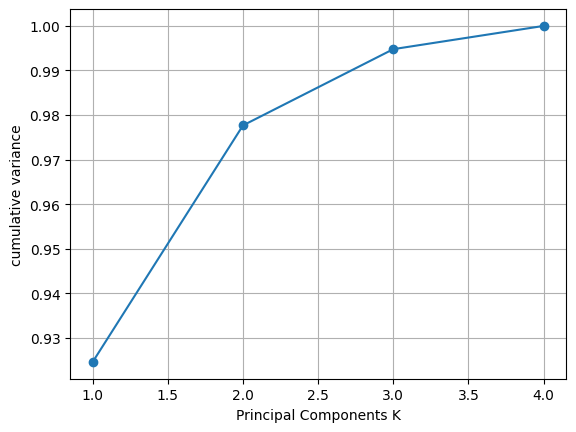

In [29]:
pca = PCA()

pca.fit(X)

var_threshold = 0.95
variance_ratios = pca.explained_variance_ratio_
cum_variance_ratios = np.cumsum(variance_ratios)

optimal_k = np.argmax(cum_variance_ratios >= var_threshold) + 1
print(f"Optimal value of k: {optimal_k}")

plt.plot(range(1, len(cum_variance_ratios) + 1), cum_variance_ratios, marker='o')
plt.xlabel('Principal Components K')
plt.ylabel('cumulative variance')
plt.grid(True)
plt.show()


In [35]:
pca = PCA(n_components=1)
reduced_X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=1)

In [36]:
KNN_best_params(X_train, X_test, y_train, y_test)

[0.9416666666666667, 0.9666666666666667, {'n_neighbors': 42}]

<!-- perform pca -->

# Custom Dataset

#### Extract Data

In [49]:
import os


path = "./Dataset/Soil types/"
subpaths = os.listdir(path)

for i in subpaths:
    print(os.listdir(path + i))


['10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '31.jpg', '32.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '4.jpg', '40.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
['1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
['1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
['1.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14

In [37]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

In [38]:
def generateDescriptorHistograms(paths: list, labels: list, KMeansModel: KMeans, cluster_size: int) -> pd.DataFrame:
    pca = PCA(n_components=77) 
    data = []
    _max = 0

    # process plain images
    for i in range(len(paths)):
        for image_path in paths[i]:
            # read image array grayscale color space
            img_arr = cv2.imread(image_path, 0)

            # extract descriptors from image
            keypoints, descriptor = extract_sift_features(img_arr)

            if(descriptor.shape[0]) < 77:
                # print(image_path)
                continue

            # do pca on descriptors
            reduced_descriptors = pca.fit_transform(descriptor)

            # generate image descriptor classes
            class_labels = KMeansModel.predict(reduced_descriptors)

            # initialize and populate histogram with 115 descriptor classes
            histogram = np.zeros(cluster_size, dtype=int)
            histogram_cropped = np.bincount(class_labels)
            histogram[:len(histogram_cropped)] = np.logical_or(histogram_cropped,histogram[:len(histogram_cropped)]) * histogram_cropped

            # store data
            data.append({"Path":image_path, "Desc_Histogram":histogram, "Class":labels[i]})
    
    df = pd.DataFrame(data)
    return df